# Life Expectancy Modelling Using Sensitive and Non-Sensitive Features

## <u>Importing Data and Libraries</u>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm
import statsmodels.tools

In [2]:
# Import dataset and save to dataframe 'le' (Life Expectancy)
le = pd.read_csv("Life Expectancy Data.csv")

## <u>Initial Data Cleaning</u>

We can do some initial **data cleaning** before the train-test-split, such as dropping columns and one-hot-encoding, as these do not cause data leakage.

In [3]:
# Displaying all columns in the data
pd.set_option('display.max_columns', None)

# Initial look-over
le.head(1)

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy
0,Turkiye,Middle East,2015,11.1,13.0,105.824,1.32,97,65,27.8,97,97,0.08,11006,78.53,4.9,4.8,7.8,0,1,76.5


We will not be using the **'Country'** column in our model as this might introduce **high bias** in the model.  
For example, if a certain country has previously had a low life expectancy, then the model would be more likely to predict a low life expectancy again, which we want to *avoid*.  
As well as that, this column would have to be one hot encoded and with 179 countries this would create too much **noise** in our model.    
So we can **drop** this column.

In [4]:
le.drop(columns = 'Country', inplace = True)

We can **rename** the columns to follow naming conventions.

In [5]:
#Rename columns

le.rename(columns={'Region':'region',
                   'Year':'year',
                   'Infant_deaths':'infant_deaths_per_1000',
                   'Under_five_deaths':'under_5_deaths_per_1000',
                   'Adult_mortality':'adult_mortality_per_1000',
                   'Alcohol_consumption':'alcohol_consumption', 
                   'Hepatitis_B':'hepatitis_b_immunization_%',
                   'Measles' : 'measles_reported_per_1000', 
                   'Polio' : 'polio_immunization_%',
                   'Diphtheria' : 'diphtheria_immunization_%',
                   'Incidents_HIV' : 'aids_deaths_per_1000',
                   'Population_mln' : 'population_million',
                   'BMI' : 'bmi',
                   'GDP_per_capita' : 'gdp_per_capita',
                   'Thinness_ten_nineteen_years' : 'thinness_prevalence_10_19',
                   'Thinness_five_nine_years' : 'thinness_prevalence_5_9',
                   'Schooling':'years_of_schooling',
                   'Economy_status_Developed' : 'developed_economy',
                   'Economy_status_Developing' : 'developing_economy',
                   'Life_expectancy' : 'life_expectancy' }, 
                   inplace=True)   # set inplace = True to replace the original column names

Next we can check if there are any **nulls** in each column.

In [6]:
# Sum the number of nulls in each column of the dataframe
le.isnull().sum()

region                        0
year                          0
infant_deaths_per_1000        0
under_5_deaths_per_1000       0
adult_mortality_per_1000      0
alcohol_consumption           0
hepatitis_b_immunization_%    0
measles_reported_per_1000     0
bmi                           0
polio_immunization_%          0
diphtheria_immunization_%     0
aids_deaths_per_1000          0
gdp_per_capita                0
population_million            0
thinness_prevalence_10_19     0
thinness_prevalence_5_9       0
years_of_schooling            0
developed_economy             0
developing_economy            0
life_expectancy               0
dtype: int64

We find that there are no null values in any columns, so we can check whether there are any **zero values** which might represent nulls or missing data.

In [7]:
## First count the number of 0s in each column:

# Sum the number of times that a 0 appears in the dataframe for each column
# Save to the 'number_of_zeros' variable
number_of_zeros = (le==0).sum()

# Create a dataframe to display this
zeros = pd.DataFrame(number_of_zeros, columns = ['number of zeros'])

## Now calculate the percentage of the column that these zero values take up:

# Divide the number_of_zeros by the length of the columns
# Multiply by 100 to get the value as a percentage
# Round to 2 decimal places
# Save to the 'percent' variable
percent = round((number_of_zeros / len(le))*100, 2)

# Add this to the dataframe
zeros['percentage of zeros'] = percent

## Return the calculations in descending order
zeros.sort_values('percentage of zeros', ascending = False)

,number of zeros,percentage of zeros
developed_economy,2272,79.33
developing_economy,592,20.67
alcohol_consumption,38,1.33
region,0,0.00
under_5_deaths_per_1000,0,0.00
infant_deaths_per_1000,0,0.00
year,0,0.00
adult_mortality_per_1000,0,0.00
bmi,0,0.00
polio_immunization_%,0,0.00


> We can see that there are **0s** in the **alcohol_consumption** column.  
> The presence of the 0s could be *intentional omission* due to cultural or religious factors.  
> Therefore, we do **not** need to remove rows containing these values.

> We also see that there are 0 values in the **developed_economy** and **developing_economy** columns.  
> These are Boolean columns, so the 0s are not a problem here.  

However, we notice that these columns are exact opposites of eachother (when **developed_economy** has a 0, **developing_economy** has a 1, and vice versa). This is supported by the sum of the percentage of 0s for these columns adding up to 100%.  

Therefore we can drop one of these columns to prevent multicollinearity.

In [8]:
# Drop developing_economoy from the dataframe
le.drop(columns = 'developing_economy', inplace = True)  # set inplace=True to replace the original

Next, we can check whether there are any **duplicates** or **non-numerical** columns.

In [9]:
# Sum the number of duplicate rows in the dataframe
le.duplicated().sum()

np.int64(0)

> There are **no** duplicate rows.

In [10]:
# Check the data types of each column
le.dtypes

region                         object
year                            int64
infant_deaths_per_1000        float64
under_5_deaths_per_1000       float64
adult_mortality_per_1000      float64
alcohol_consumption           float64
hepatitis_b_immunization_%      int64
measles_reported_per_1000       int64
bmi                           float64
polio_immunization_%            int64
diphtheria_immunization_%       int64
aids_deaths_per_1000          float64
gdp_per_capita                  int64
population_million            float64
thinness_prevalence_10_19     float64
thinness_prevalence_5_9       float64
years_of_schooling            float64
developed_economy               int64
life_expectancy               float64
dtype: object

> The **'region'** column has **'object'** data type, which cannot be used in the Linear Regression model. To fix this, we will **one-hot-encode it**.  

> We also one-hot-encode the **'year'** column to prevent the model from interpreting more recent years as higher values.

In [11]:
# Define a function that performs the one-hot-encoding
def feature_eng(le):
    
    # Create a copy of the inputted dataframe
    df_local = le.copy()
    
    # Perform one-hot-encoding on the 'region' column
    # Drop the first column to prevent multicollinearity
    df_local = pd.get_dummies(df_local, columns=['region'], drop_first=True, dtype=int)
    
    # Repeat on the 'year' column
    df_local = pd.get_dummies(df_local, columns=['year'], drop_first=True, prefix='year', dtype=int)
    
    # Return the dataframe
    return df_local 

In [12]:
# Apply the feature engineering function to the dataframe
# And save as a new dataframe, le_fe
le_fe = feature_eng(le)

## <u>Train-Test-Split </u>

We can now split the data into **80% training** data and **20% testing** data.  

We can also **stratify** the data, since we performed one-hot-encoding before performing the train-test-split. This will preserve the target distribution.

In [13]:
# The feature columns are all columns except 'life_expectancy'
# So we drop this column and save as a new dataframe, X
X = le_fe.drop('life_expectancy', axis=1)

# The target column in 'life_expectancy'
y = le_fe['life_expectancy']

# Create bin sizes for stratifying
y_strat_bin = pd.cut(y, bins=4, labels=False)

# Perform the split and assign to the corresponding variables
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,        # set test_size to 20%
                                                    random_state = 100,     # fix the random state to a random number
                                                    stratify= y_strat_bin   # stratify the data
                                                   )

We can now continue performing additional cleaning and further exploratory analysis on the **training dataset** to prevent data leakage.  

## <u>Investigating the Target Variable</u> 

First we can create a histogram showing the distribution of the target variable (y_train).

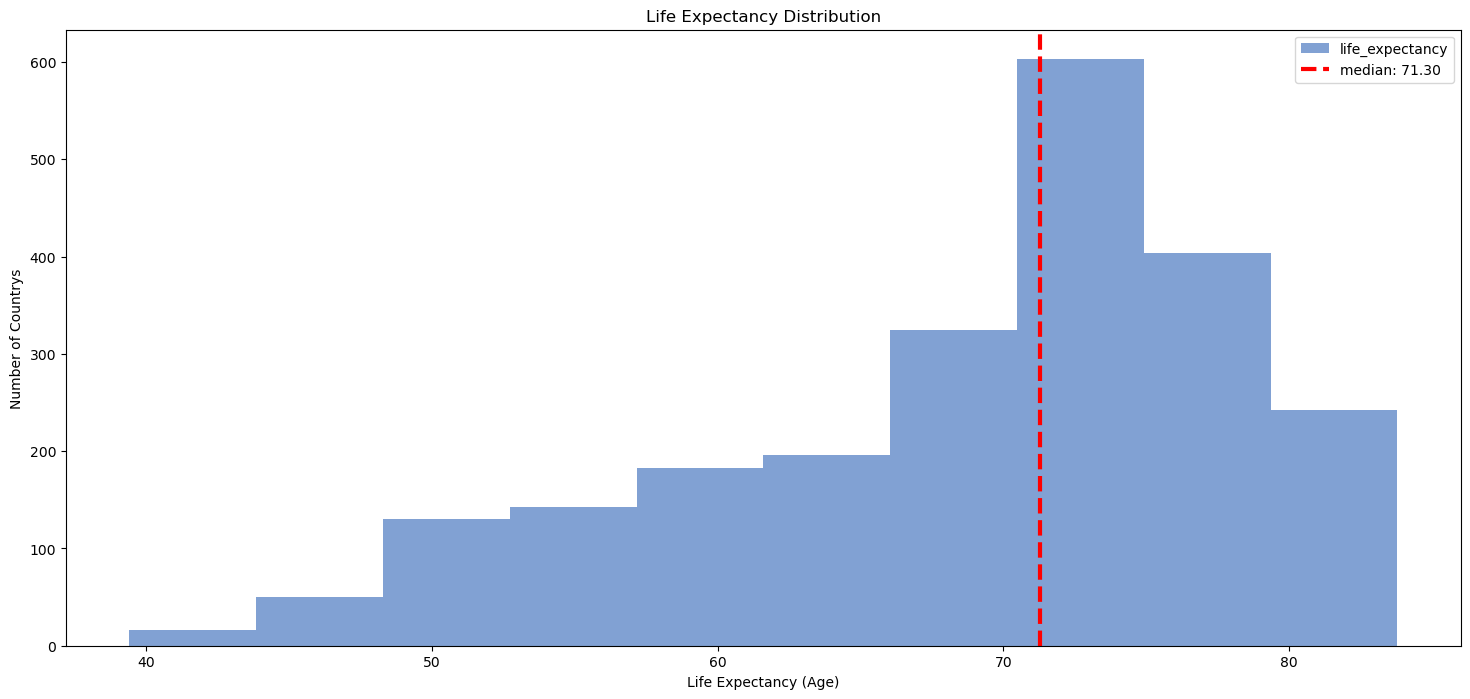

In [14]:
# Set the figure size
plt.figure(figsize=(18,8))

# Plot a histogram of y_train
y_train.plot(kind='hist', 
             color='#81A1D3',  # Set colour of bars
             bins=10)          # Set 10 total bins

# Calculate the median value of the y_train column
median_value = y_train.median()

# Plot the median value as a line on the graph
# SOURCE: https://nsdsda.medium.com/visualizing-mean-median-mode-and-standard-deviation-all-together-e8a3ddec61a8
plt.axvline(median_value, 
            color='red',                          # set colour of the line
            linestyle='dashed',                   # make it a dashed line
            linewidth=3,                          # set the width 
            label=f'median: {median_value:.2f}'   # add a label to the line and show to 2dp
           )


# Display the labels for median line and life expectancy bars
plt.legend()

# Add a title to the graph
plt.title('Life Expectancy Distribution')

# Label the x and y axes
plt.ylabel('Number of Countrys')
plt.xlabel('Life Expectancy (Age)')

# Display the graph
plt.show()

Higher life expectancy is desirable, as we want people to live longer and healthier lives.    

 In our data, life expectancy is **positively skewed**, which is shown by most of the values being concentrated at the higher end, and a smaller number of lower values forming the tail.  

 We explored applying a **logarithmic transformation** to Life Expectancy to reduce skewness and help the model capture proportional differences. However, once applied to the model, it did not make a significant difference, so the transformation was not used.  

 Next we can create a boxplot of the life expectancy to identify any outliers.

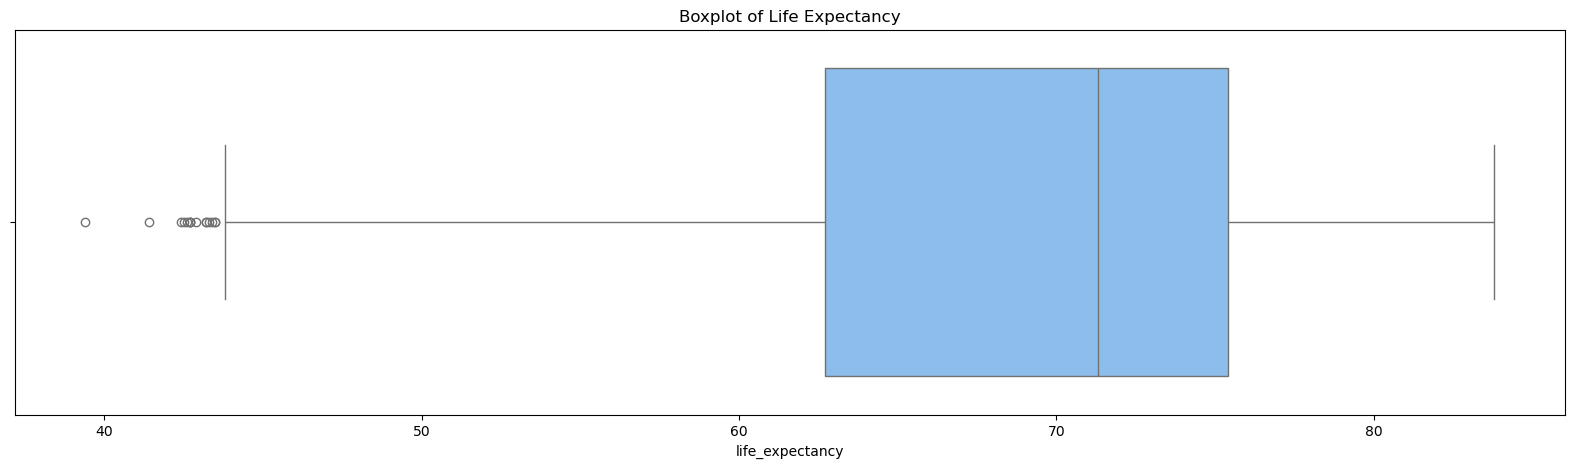

In [15]:
# Set figure size
plt.figure(figsize=(20, 5))

# Create a boxplot of y_train values
sns.boxplot(data=y_train,
            color='#7EBDF9',   # set colour of bars
            orient='h',        # display boxplot horizontally
            whis=1.5           # set whisker size to 1.5x the IQR
            )

# Add a title to the plot
plt.title("Boxplot of Life Expectancy")

# Display the graph
plt.show()

In the box plot above, we can observe some outliers below the lower whisker.  
We can calculate both the total number of **outliers** and the number of **extreme outliers** to assess their potential impact on the model.

In [16]:
# Calculate the lower quartile of y_train
Q1 = y_train.quantile(0.25)

# Calculate the upper quartile of y_train
Q3 = y_train.quantile(0.75)

# Calculate the interquartile range
IQR = Q3 - Q1

## Calculating the total number of outliers:

# Select all of the values in y_train that fall below the lower boundary
# (i.e. less than 1.5x the IQR)
# Use .count() to count how many values satisfy this condition
outliers = y_train[y_train < (Q1 - 1.5 * IQR)].count()

# Print the number of outliers
print("Number of Outliers:", outliers)

## Calculating the number of extreme outliers:

# Select all values in y_train that fall below extreme lower boundary
# (i.e. less than 3x the IQR)
# Use .count() to count how many values satisfy this condition
extreme_outliers = y_train[y_train < (Q1 - 3 * IQR)].count()

# Print the number of extreme outliers
print("Number of Extreme Outliers:", extreme_outliers)

Number of Outliers: 15
Number of Extreme Outliers: 0


The **outliers** in y_train are **not** classified as **extreme**, so they are retained.  
These outliers reflect real **variations** in economic and health conditions which are important for understanding disparities, and could **help inform policies** and guide interventions. Removing them could reduce model accuracy for extreme cases.

## <u>Investigating the Features</u> 

<img src = "https://github.com/izzybenson03/WHO-project/blob/main/Disease.png?raw=true" width = 700px, height=900px/>

The bar chart shows that the **average coverage** of **polio** immunisation is extremely **similar** to the average coverage of **diphtheria** among 1-year-olds. This links to our correlations and assists in the reasoning of why we have chosen to drop the ‘polio_immunization_%’ column for our model. 

<img src = "https://github.com/izzybenson03/WHO-project/blob/main/Thinness.png?raw=true" width = 700px, height=900px/>

Once again, **thinness of ten to nineteen years** has a high correlation with **thinness of five to nine years** as we saw above. This links to our graph as it shows the average thinness per region for both of these features as being very close to one another. This assists in our reasoning for dropping the ‘thinness_prevalence_10_19’ column.

<img src = "https://github.com/izzybenson03/WHO-project/blob/main/Child%20deaths.png?raw=true" width = 700px, height=900px/>

Finally, we see that the **total infant deaths** and **under five deaths** across regions is also similar. The correlation between these features is explored below and shows that only one of these needs to stay in the model to avoid multicollinearity. 

<img src = "https://github.com/izzybenson03/WHO-project/blob/main/Life%20expectancy.png?raw=true" width = 700px, height=900px/>

From this graph we can see that the regions with the **highest life expectancy** are also the darkest, meaning they have an average **economy status** of close 1 which in this case is classed as **developed**.  

The regions that have the most developing countries are also found to have a lower average life expectancy. This can show that **economy status** has an **important effect** on life expectancy and is a feature that **cannot be dropped** from our model.

### <u>Correlations</u>

There are some features that could show **multicollinearity**.  
We can first explore this with a **correlation matrix**.

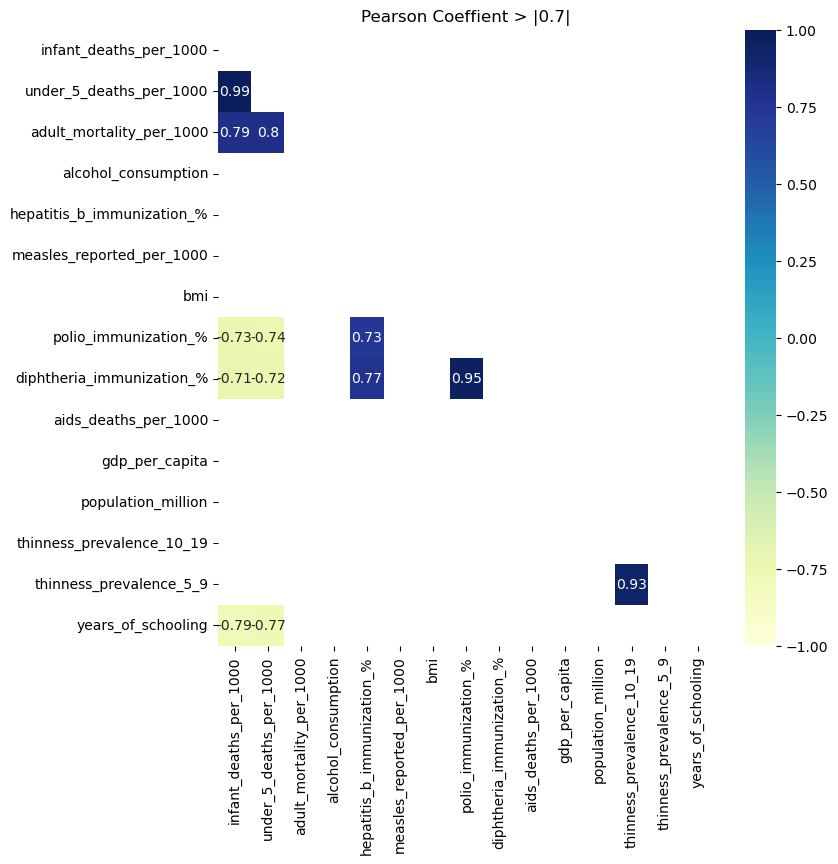

In [17]:
# Calculate the correlation between all feature columns
# Except the one-hot-encoded ones
# i.e. select columns of index 0 to 17
corr_matrix = X_train.iloc[:, 0:15].corr()

# Create a mask for the correlations which only shows correlations that
# are greater than 0.7 or smaller than -0.7.
mask1 = np.abs(corr_matrix) <= 0.7

# Create a mask which only shows the lower half of the matrix
mask2 = np.triu(corr_matrix) 

# Combine both masks
combined_mask = mask1|mask2

# Set the size of the graph
plt.figure(figsize=(8,8))

# Plot the correlation matrix on a heatmap
sns.heatmap(corr_matrix,
            vmin = -1,           # set the minimum value
            vmax = 1,            # set the maximum value
            annot=True,          # display correlation values
            mask=combined_mask,  # apply the combined mask
            cmap='YlGnBu')       # set the colour palette

# Add a title to the heatmap
plt.title("Pearson Coeffient > |0.7|")

# Display
plt.show()

Following from this, we can explore all of the columns which have a **strong correlation** with another column. We do this by calculating the **VIF** between each pair of columns. We have only shown the correlations that are above **0.7** as this shows a **strong correlation** and gives us information on which features we should look further into.

In [18]:
## SOURCE FOR CODE BELOW:
# https://www.geeksforgeeks.org/python/detecting-multicollinearity-with-vif-python/

In [19]:
# Select two features that have a Pearson's Correation Coeeficient > 0.7
# As these could show multicollinearity
features1 = X_train[['infant_deaths_per_1000', 'under_5_deaths_per_1000']]

# Create a new dataframe to hold the VIF values for this comparison 
vif_data1 = pd.DataFrame()

# Add the feature column to the dataframe
vif_data1['features1'] = features1.columns

# Add the VIF column to the dataframe
# Calculate the VIF for each feature in the dataframe
# Then iterate through column indices (indicies created using (features1.shape[1])) 
# to calculate VIF for each feature.
vif_data1['VIF'] = [variance_inflation_factor(features1.values, i)
                    for i in range(features1.shape[1])]

# Display the VIFs
display(vif_data1)

,features1,VIF
0,infant_deaths_per_1000,52.51563
1,under_5_deaths_per_1000,52.51563


In [20]:
# Repeating the above process for all other correlated features
# We calculated this for all columns in the correlation matrix, but we show the code for the ones
# that had a VIF greater than 5

features2 = X_train[['polio_immunization_%', 'diphtheria_immunization_%']]
vif_data2 = pd.DataFrame()
vif_data2['features'] = features2.columns
vif_data2['VIF'] = [variance_inflation_factor(features2.values, i) for i in range(features2.shape[1])]
display(vif_data2)

features3 = X_train[['thinness_prevalence_5_9', 'thinness_prevalence_10_19' ]]
vif_data3 = pd.DataFrame()
vif_data3['features'] = features3.columns
vif_data3['VIF'] = [variance_inflation_factor(features3.values, i) for i in range(features3.shape[1])]
display(vif_data3)

,features,VIF
0,polio_immunization_%,350.107582
1,diphtheria_immunization_%,350.107582


,features,VIF
0,thinness_prevalence_5_9,16.991802
1,thinness_prevalence_10_19,16.991802


Polio and Diphtheria are both early childhood vaccinations, so children usually receive either both or neither, possibly explaining their high multicollinearity. 

As shown in the VIF values calculated for the **correlated pairings** in the matrix above, these variables have VIFs exceeding the typical cutoff of 10. To reduce **multicollinearity** in the model, one variable from each highly correlated pair will be dropped, making the model easier to interpret and the remaining features more reliable.

Now we can calculate the the VIF for all of the columns, to decide which ones to drop.

In [21]:
# Calculating the VIF for all columns (except one-hot-encoded)
# i.e. columns with index 0 to 15
features6 = X_train.iloc[:, 0:15]

vif_data_drop = pd.DataFrame()
vif_data_drop['features'] = features6.columns
vif_data_drop['VIF'] = [variance_inflation_factor(features6.values, i) for i in range(features6.shape[1])]

# Display the VIF for each column in descending order
vif_data_drop = vif_data_drop.sort_values(by='VIF', ascending=False)
display(vif_data_drop)

,features,VIF
8,diphtheria_immunization_%,410.275453
7,polio_immunization_%,404.820331
6,bmi,94.391533
0,infant_deaths_per_1000,92.882537
1,under_5_deaths_per_1000,80.460672
4,hepatitis_b_immunization_%,77.337596
14,years_of_schooling,28.767798
5,measles_reported_per_1000,28.700943
2,adult_mortality_per_1000,27.791577
12,thinness_prevalence_10_19,18.587572


We can see that: 
* **'diphtheria_immunization_%'** has a higher VIF than **'polio_immunization_%'**
* **'thinness_prevalence_10_19'** has a higher VIF than **'thinness_prevalence_5_9'**
* **'infant_deaths_per_100'** has a higher VIF than **'under_5_deaths_per_1000'** 


So we can drop the columns with the **higher** VIF.

In [22]:
# Drop the columns from train data
X_train_drop = X_train.drop(columns = ['infant_deaths_per_1000',
                                            'diphtheria_immunization_%',
                                            'thinness_prevalence_10_19'])

# Drop the columns from test data
X_test_drop = X_test.drop(columns =['infant_deaths_per_1000',
                                         'diphtheria_immunization_%',
                                         'thinness_prevalence_10_19'])

We also tested the negative VIFs but none of them were significant. 

### <u>Logarithmic Correlations</u>

Now we can explore which features have logarithmic correlations by creating a pairplot.

A pairplot of all variables was created to visually assess the relationships between the target variable and the features. Due to the computational time required to print the plot, the code has been placed in a markdown cell. However, it can be viewed by converting the cell back to a code cell.

df_pairwise = pd.concat([X_train_drop, y_train], axis=1)

sns.pairplot(df_pairwise[[''under_5_deaths_per_1000','adult_mortality_per_1000',  
       'alcohol_consumption','hepatitis_b_immunization_%','measles_reported_per_1000',  
       'polio_immunization_%','aids_deaths_per_1000','population_million',  
       'bmi','gdp_per_capita','thinness_prevalence_5_9',  
       'years_of_schooling', 'life_expectancy']], height = 6)
 plt.show()

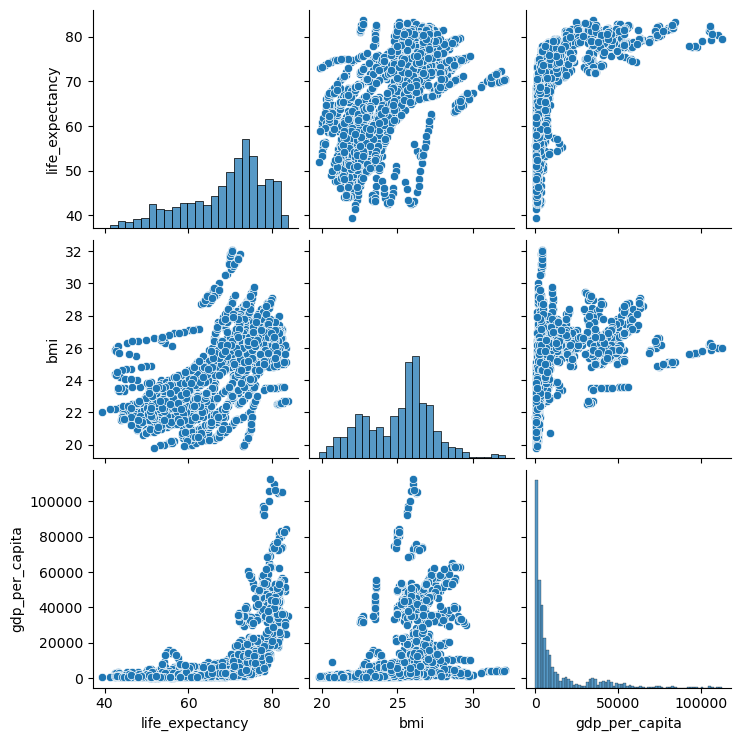

In [23]:
# Pairplot of the columns we found to have a logarithmic relationship
df_pairwise = pd.concat([X_train_drop, y_train], axis=1)

sns.pairplot(df_pairwise[['life_expectancy', 'bmi', 'gdp_per_capita']], height=2.5)

plt.show()

In [24]:
#log transformation on bmi and gdp per capita 
#logerthimic nature shown in pairwise plot 
X_train_drop['bmi_log'] =  np.log(X_train_drop['bmi'])
X_train_drop['gdp_per_capita_log'] =  np.log(X_train_drop['gdp_per_capita']) 

X_test_drop['bmi_log'] =  np.log(X_test_drop['bmi'])
X_test_drop['gdp_per_capita_log'] =  np.log(X_test_drop['gdp_per_capita']) 

X_train_drop.drop(columns = 'bmi', inplace = True)
X_train_drop.drop(columns = 'gdp_per_capita', inplace = True)
X_test_drop.drop(columns = 'bmi', inplace = True)
X_test_drop.drop(columns = 'gdp_per_capita', inplace = True)



Both **BMI** and **GDP per capita** show a logarithmic relationship with the target variable, so a **log transformation** was applied to these features. This reduces **heteroskedasticity**, stabilising the variance of the residuals. The linear regression assumptions are better satisfied, improving the models predictions.

## <u>Scaling</u>

First, we **scale** the columns which have not been one-hot-encoded, as there is a large **difference in magnitudes** between these columns.

#### <u>Scaling the 'train' data:<u/>

In [25]:
# Create a copy of the dataframe
X_train_final = X_train_drop.copy()

# Initialise the Robust Scaler
rob = RobustScaler()

# Define columns that need scaling (Non-Boolean columns)
rob_features = ['under_5_deaths_per_1000',
                'adult_mortality_per_1000',
                'alcohol_consumption',
                'hepatitis_b_immunization_%',
                'measles_reported_per_1000',
                'polio_immunization_%',
                'aids_deaths_per_1000',
                'population_million',
                'years_of_schooling']

# Select these columns from the dataframe
# Then fit and transform these columns
X_train_final[rob_features] = rob.fit_transform(X_train_drop[rob_features])

#### <u>Scaling the 'test' data:</u>

In [26]:
# Create a copy of the dataframe
X_test_final = X_test_drop.copy()

# Select the same columns as before from the dataframe
# Fit and transform these columns
X_test_final[rob_features] = rob.transform(X_test_drop[rob_features])

## <u>Modelling</u> 

In [27]:
# Add a constant to the train data to prepare for StatsModels method
X_train_final = sm.add_constant(X_train_final)

# Add a constant to the test data
X_test_final = sm.add_constant(X_test_final)

### <u>Simplified Model</u> 

First we can create the model based on **non-sensitive** data.  
This model takes the columns:
* region
* year
* gdp_per_capita
* years_of_schooling
* developed_economy


  
We have deemed the other columns here as sensitive and removed them from our model for multiple reasons:   

* Polio, HIV/AIDS, Diphtheria, Measles, Hepatitis B, Under 5 Deaths, Adult Mortality: These can be viewed as **personal data** as countries will have to access individual health records to find results.  


* Alcohol Consumption: Some countries may **not** want to **disclose** this information and give a result of 0 if drinking alcohol doesn't align with their views e.g. **religious countries**. Individuals may also not want this information given out or may not disclose the true value.  


* Thinness 5-9 & 10-19: Describing a child as **'thin'** based on factors such as BMI can be seen as unethical and takes into account **personal health** records that may not want to be shared.  


* Infant Deaths, Economy Status Developing: These were taken out due to high **correlations** with Under Five Deaths and Economy Status Developed respectively.  


* Population Million, Years of Schooling: These were removed due to having a high **P Value**, as shown in the following section.


In [28]:
# Drop the features that we deem to be sensitive from the train data
X_train_simple = X_train_final.drop(columns = ['under_5_deaths_per_1000',
                                               'adult_mortality_per_1000',
                                               'alcohol_consumption',
                                               'hepatitis_b_immunization_%',
                                               'measles_reported_per_1000',
                                               'bmi_log',
                                               'polio_immunization_%',
                                               'aids_deaths_per_1000',
                                               'thinness_prevalence_5_9']
                                   )

# Drop the same features from the test data
X_test_simple = X_test_final.drop(columns = ['under_5_deaths_per_1000',
                                             'adult_mortality_per_1000',
                                             'alcohol_consumption',
                                             'hepatitis_b_immunization_%',
                                             'measles_reported_per_1000',
                                             'bmi_log',
                                             'polio_immunization_%',
                                             'aids_deaths_per_1000',
                                             'thinness_prevalence_5_9']
                                   )

We ran the simple model with all remaining columns and found that the **'population_million'** column had a very high P-Value (0.083), and **'years_of_schooling'** also had a high P-Value (0.254).

So we can drop these columns from the simple model to reduce the condition number and remove noise from the model.

In [29]:
# Drop column from train data
X_train_simple = X_train_simple.drop(columns = ['population_million', 'years_of_schooling'])

# Drop column from test data
X_test_simple = X_test_simple.drop(columns = ['population_million', 'years_of_schooling'])

#### <u>Training the model</u> 

In [30]:
# The feature columns are X_train_simple, and the target column is y_train

# Initialise the model
linreg_simple = sm.OLS(y_train, X_train_simple)

# Fit the model and save to 'results_simple'
results_simple = linreg_simple.fit()

In [31]:
# Return the summary calculations from the model
results_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     339.7
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:52:35   Log-Likelihood:                -6600.7
No. Observations:                2291   AIC:                         1.325e+04
Df Residuals:                    2265   BIC:                         1.340e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   33.1998      0.809     41.043      0.000      31.613      34.786
developed_economy                        1.8653      0.525      3.552      0.000       0.836       2.895
region_Asia                              9.2348      0.298     30.970      0.000       8.650       9.820
region_Central America and Caribbean     9.8609      0.358     27.571      0.000       9.160      10.562
region_European Union                    8.7584      0.549     15.950      0.000       7.682       9.835
region_Middle East                       8.9155      0.423     21.083      0.000       8.086       9.745
region_North America                     8.7896      0.789     11.142      0.000       7.243      10.337
region_Oceania                           7.4421      0.414     17.977      0.000       6.630       8.254
region_Rest of Europe                   10.5365      0.393     26.805      0.000       9.766      11.307
region_South America                     9.7717      0.417     23.406      0.000       8.953      10.590
year_2001                               -0.1073      0.512     -0.210      0.834      -1.111       0.896
year_2002                               -0.0328      0.517     -0.064      0.949      -1.046       0.980
year_2003                               -0.1054      0.510     -0.207      0.836      -1.106       0.895
year_2004                                0.6300      0.510      1.236      0.217      -0.370       1.630
year_2005                                0.6933      0.508      1.364      0.173      -0.304       1.690
year_2006                                0.6874      0.517      1.330      0.184      -0.326       1.701
year_2007                                0.9257      0.512      1.808      0.071      -0.078       1.930
year_2008                                1.8565      0.510      3.638      0.000       0.856       2.857
year_2009                                1.8008      0.507      3.551      0.000       0.806       2.795
year_2010                                2.2921      0.512      4.473      0.000       1.287       3.297
year_2011                                2.5396      0.518      4.902      0.000       1.524       3.556
year_2012                                3.0458      0.516      5.900      0.000       2.033       4.058
year_2013                                2.7297      0.507      5.380      0.000       1.735       3.725
year_2014                                3.3547      0.509      6.597      0.000       2.357       4.352
year_2015                                3.3538      0.506      6.625      0.000       2.361       4.347
gdp_per_capita_log                       3.2337      0.102     31.787      0.000       3.034       3.433
======================================

> We can **evaluate** the model using the following statistics:  

* **R^2 = 0.789**, meaning that around 79% of the variation in life expectancy is explained by our model.

* **AIC = 1.325e+04** and **BIC = 1.340e+04**, which is quite high for the simple model as expected, due to removing many columns for ethical practise.  

* **Cond. No = 141** which did not trigger the condition warning number, indicating that there is no multicollinearity and the model is stable.

In [32]:
# Create a prediction of y using the model
y_pred_train_simple = results_simple.predict(X_train_simple)

# Calculate RMSE
print(statsmodels.tools.eval_measures.rmse(y_train, y_pred_train_simple))

4.315421644775331


#### <u>Test model</u> 

In [33]:
# The feature columns are X_test_simple, and the target column is y_test

# Now we can create a prediction of y using the X_test_non_sensitive features
y_pred_test_simple = results_simple.predict(X_test_simple)

# Calculate RMSE
print(statsmodels.tools.eval_measures.rmse(y_test, y_pred_test_simple))

4.339748049845984


> We get an **RMSE** of 4.34. This means that on average, the predicted life expectancy will be around 4 years away from the real value.

### <u>Advanced Model</u> 

Now we can create the more **accurate model** which uses all available information.

#### <u>Training the Model</u>

We ran the advanced model with all remaining columns and found that many columns had **high P-Values.**  

So we can drop the columns which **reduced AIC and BIC**, while **not** affecting RMSE or R^2 too much.  

This will reduce _noise_ in the advanced model.

In [34]:
# The following columns had high P values:
    # thinness_prevalence_5_9(0.958)
    # measles_reported_per_1000 (0.898)
    # alcohol_consumption (0.354)
    # population_million (0.204)
    # year columns


# Drop from the train data
X_train_advanced = X_train_final.drop(columns = ['alcohol_consumption',
                                                 'measles_reported_per_1000', 
                                                 'polio_immunization_%',
                                                 'thinness_prevalence_5_9',
                                                 'population_million']
                                     )


# Drop from the test data
X_test_advanced = X_test_final.drop(columns = ['alcohol_consumption',
                                               'measles_reported_per_1000', 
                                               'polio_immunization_%',
                                               'thinness_prevalence_5_9',
                                               'population_million']
                                   )

In [35]:
# The year columns also had high P values
# So we can drop these

# Perform on both train data and test data
for i in [X_train_advanced, X_test_advanced]:
    
    # iterate through columns
    for j in i.columns:
        
        # if column starts with year_
        if j.startswith('year_'):
            
            # drop the column
            i.drop(j, axis=1, inplace=True)

Now we can run the model.

In [36]:
# X_train_final contains the feature columns
# y_train contains the target column

# Create the linear regression object
linreg_advanced = sm.OLS(y_train, X_train_advanced)

# Fit the model and save to 'results'
results_advanced = linreg_advanced.fit()

In [37]:
# Return the summary calculations from the model
results_advanced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     8324.
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:52:36   Log-Likelihood:                -3703.6
No. Observations:                2291   AIC:                             7441.
Df Residuals:                    2274   BIC:                             7539.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   80.9721      1.738     46.582      0.000      77.563      84.381
under_5_deaths_per_1000                 -4.3933      0.086    -51.005      0.000      -4.562      -4.224
adult_mortality_per_1000                -6.4213      0.085    -75.792      0.000      -6.587      -6.255
hepatitis_b_immunization_%              -0.0690      0.035     -1.954      0.051      -0.138       0.000
aids_deaths_per_1000                     0.0254      0.007      3.661      0.000       0.012       0.039
years_of_schooling                       0.6180      0.096      6.441      0.000       0.430       0.806
developed_economy                        2.5533      0.160     15.912      0.000       2.239       2.868
region_Asia                              0.0150      0.108      0.139      0.890      -0.196       0.226
region_Central America and Caribbean     1.6483      0.117     14.043      0.000       1.418       1.878
region_European Union                   -0.9257      0.176     -5.270      0.000      -1.270      -0.581
region_Middle East                      -0.0247      0.136     -0.182      0.855      -0.291       0.241
region_North America                     0.4992      0.238      2.097      0.036       0.032       0.966
region_Oceania                          -1.0419      0.141     -7.369      0.000      -1.319      -0.765
region_Rest of Europe                    0.2665      0.141      1.894      0.058      -0.009       0.542
region_South America                     1.3832      0.132     10.480      0.000       1.124       1.642
bmi_log                                 -4.1958      0.542     -7.747      0.000      -5.258      -3.134
gdp_per_capita_log                       0.4255      0.040     10.537      0.000       0.346       0.505
==============================================================================
Omnibus:                        5.025   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.081   Jarque-Bera (JB):                4.984
Skew:                           0.097   Prob(JB):                       0.0827
Kurtosis:                       3.122   Cond. No.                         675.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Again we can focus on the following metrics:  

* **R^2 = 0.983**, meaning that around 98% of the variation in life expectancy is explained by our model - which is almost perfect!  

* **AIC = 7441** and **BIC = 7539**, which is much lower than the simple model, and was lower than other advanced models we tested, contributing to our choice of this model over others.

* **Cond. No = 675** which is higher but still did not trigger the condition number warning so there are no multicollinearity issues and the model is stable.

In [38]:
# Create a prediction of y using the model
y_pred_train_advanced = results_advanced.predict(X_train_advanced)

# Calculate RMSE
print(statsmodels.tools.eval_measures.rmse(y_train, y_pred_train_advanced))

1.2185124182881524


#### <u>Testing the Model</u>

In [39]:
# The feature columns are X_test_final
# The target column is y_test

# Now we can create a prediction of y using the X_test_final columns
y_pred_test = results_advanced.predict(X_test_advanced)

# Calculate RMSE
print(statsmodels.tools.eval_measures.rmse(y_test, y_pred_test))

1.2087001605621575


>The **RMSE** is equal to **1.21**. This means that when a country inputs their data into our model, the prediction will be within roughly 1 year of the actual value, indicating that this is a great model!

## <u>Conclusion</u>

To recap:  

* We created a highly ethical model which does not use sensitive data.  


* We also created a highly accurate and robust model which uses more features.  


* Our versatile function enables the user to manually input or to upload a CSV.  


* Choose us or miss out on a brilliant prediction!
